# About
Single-step univariate Bidirectional Long-Short term memory (Bi-LSTM)

# Univariate Time Series
Univariate time series are datasets comprised of a single series of observations with a temporal ordering and a model is required to learn from the series of past observations to predict the next value in the sequence.
-  The CNN model will learn a function that maps a sequence of past observations as input to an output observation

## Note:
* The chosen configuration of the models is arbitrary and not optimized for each problem; that was not the goal.

# Libraries

In [1]:
%run "/home/cesar/Python_NBs/HDL_Project/HDL_Project/global_fv.ipynb"

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data
from sklearn.model_selection import train_test_split

# DL Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

# Optimizer
from tensorflow.keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Checkpoint
from keras.callbacks import ModelCheckpoint

# User-Defined Functions

In [3]:
def design_model(n_steps, lr, n_features = 1):
    """
    n_steps: Number of steps
    n_features: Number of features
    lr: Learning rate
    """
    # We define a 1D CNN Model for univariate time series forecasting as follows:
    model = Sequential(name = "Bidirectional-LSTM-model")
    
    # Number of neurons (nodes) are just about greater than the number of features.
    # Rule of thumb is for number of neurons to be about 2/3 of the input    
    num_neurons = 8
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(num_neurons, activation= 'relu' ), input_shape=(n_steps, n_features)))
    
    # Output layer with one neuron to a model instance (to return one output)
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Regularization prevents the learning process to completely fit the model to the training data which can lead to overfitting.
    # The most common regularization method is dropout.
    #model.add(layers.Dropout(0.1))    
    
    # Optimizer
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt,  metrics=['mae'], loss= 'mse')
    
    return model

In [4]:
def fit_model_es_checkpoint(X, y, learning_rate, num_epochs, bs, model):
    checkpoint_name = 'Trained_Models/U_Weights_Bi-LSTM_-{val_loss:.5f}--{epoch:03d}.hdf5'
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
    checkpoint_callback = ModelCheckpoint(checkpoint_name, monitor='mae', verbose=0, save_best_only=True, mode='min')
    history = model.fit(X, y, epochs=num_epochs, batch_size=bs, validation_split = 0.30, verbose = 0, shuffle = False, callbacks=[early_stopping_callback, checkpoint_callback])
    return history

# Data

##  Parameters

In [5]:
# SQL commands to retrieve data
sql_table = "sima_pm25"
column = "NE"
sql_where = "where datetime >= \'2020-04-17\'"

# Percentage of time series dedicated for test split
test_partition = 0.3

# Number of time steps per sample
n_steps = 24

## Data Preparation

## Sample preparation

In [6]:
uni_ts = univariate_samples(sql_table, column, sql_where)
X, y = uni_ts.samples_creation(n_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_partition, shuffle= False)

In [7]:
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))
print()
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print()
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X shape: (63912, 24)
y shape: (63912,)

X_train shape: (44738, 24)
y_train shape: (44738,)

X_test shape: (19174, 24)
y_test shape: (19174,)


# Model Definition

## Parameters

In [8]:
lr = 0.01
# Maximum number of epochs
num_epochs = 100

#fixed number of batches
batch_size = 7

In [9]:
# Define the model
model = design_model(n_steps, lr)
model.summary()

Model: "Bidirectional-LSTM-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16)               640       
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


# Training the model

Elapsed time is 689.840298 seconds.


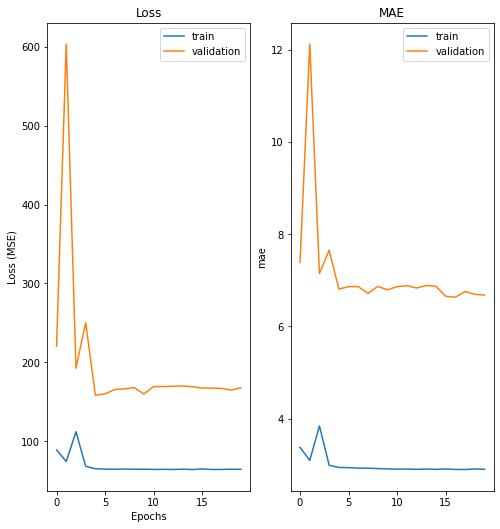

Min training Loss: 64.23046875
Min validation Loss:  158.42587280273438

Final training MAE: 2.8990795612335205
Final validation MAE: 6.6777520179748535


In [10]:
# Train
#Training with early stopping

t.tic() #Start timer
history = fit_model_es_checkpoint(X_train, y_train, lr, num_epochs, batch_size, model)
t.toc() #Time elapsed since t.tic()

# Visualization
train_val_plot(history)

In [11]:
history.history

{'loss': [89.04357147216797,
  74.38803100585938,
  112.05596160888672,
  68.36540985107422,
  65.2228775024414,
  64.71910858154297,
  64.60748291015625,
  64.82230377197266,
  64.60147094726562,
  64.61979675292969,
  64.35889434814453,
  64.4833755493164,
  64.34404754638672,
  64.68728637695312,
  64.23046875,
  64.970458984375,
  64.2669677734375,
  64.29461669921875,
  64.58240509033203,
  64.46636962890625],
 'mae': [3.3765029907226562,
  3.0929033756256104,
  3.8388547897338867,
  2.9855711460113525,
  2.9398815631866455,
  2.9348044395446777,
  2.9263546466827393,
  2.9241302013397217,
  2.915003776550293,
  2.9079883098602295,
  2.9027912616729736,
  2.904581308364868,
  2.8994927406311035,
  2.9048666954040527,
  2.898268222808838,
  2.9066965579986572,
  2.896852493286133,
  2.8947129249572754,
  2.9073195457458496,
  2.8990795612335205],
 'val_loss': [220.37188720703125,
  603.3408813476562,
  192.5017852783203,
  250.2138671875,
  158.42587280273438,
  160.13217163085938,

# Testing the model
As long as two models share the same architecture you can share weights between them. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

In [12]:
# Define the model
model = design_model(n_steps, lr)
model.summary()

Model: "Bidirectional-LSTM-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [13]:
folder_models = "Trained_Models"
file_path = str(os.getcwd()) + "/" + folder_models 
file_pre = "/U_Weights_Bi-LSTM*"

weights_files = list(glob.glob(file_path + file_pre))
weights_files.sort()

weights_files = [f[len(file_path)+1:] for f in weights_files]

In [14]:
print("Loaded file:", weights_files[0])

# Choosing the best checkpoint (lowest error)
weights_file = folder_models + "/" + weights_files[0] 

# Loading it
model.load_weights(weights_file) 

Loaded file: U_Weights_Bi-LSTM_-158.42587--005.hdf5


In [15]:
tmp_df = pd.DataFrame(testing_evaluation(X_test, y_test, model), index=[0])
tmp_df.insert(0, "Model", "CNN", True)
tmp_df

,Model,RMSE,MAE,MAPE,R^2,Max Error
0,CNN,9.175552,6.024446,2.154619e+15,0.624188,400.710596


# Sources
* https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
* https://www.tensorflow.org/tutorials/keras/save_and_load